In [11]:
from __future__ import division
import numpy as np
import cv2
from skimage.transform import resize
import tensorflow as tf
from keras.models import load_model
import matplotlib.pyplot as plt
from glob import glob
import time
import os

from ops import *
from utils import *

Today we are going to train GAN for generating faces and then we will make fun playing with it. Generative adversarial networks (GANs) are deep neural net architectures comprised of two nets, pitting one against the other (thus the “adversarial”). One neural network, called the generator, generates new faces, while the other, the discriminator,  decides whether each instance of face it reviews belongs to the actual training dataset or not.

Firstly download aligned faces of celebrities from here <a href="https://yadi.sk/d/xjuClJJH3MAVXh">link</a> and extract them into folder near ipython notebook.

# Implementation of GAN

Constant variables below depends on your dataset and choosing of architecture.

In [2]:
DATA_PATH = './img_align_celeba/img_align_celeba/' # Path to the dataset with celebA faces
Z_DIM=100 # Dimension of face's manifold
GENERATOR_DENSE_SIZE=1024 #64*8 # Length of first tensor in generator

IMAGE_SIZE=64 # Shapes of input image
BATCH_SIZE=64 # Batch size
N_CHANNELS = 3 # Number channels of input image

MERGE_X = 8 # Number images in merged image

In [5]:
assert(os.path.exists(DATA_PATH)), 'Please, download aligned celebA to DATA_PATH folder'

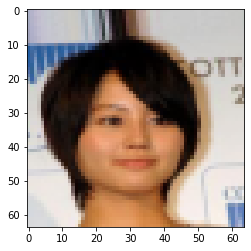

In [40]:
img = cv2.imread(os.path.join(DATA_PATH, '002514.jpg'), 1)[:,:,::-1]
plt.imshow(resize(img, [IMAGE_SIZE, IMAGE_SIZE, 3]))

Let's define GAN. To do it, we need to define generator, discriminator and loss functions.

Here are some tips on the architecture of the generator:
1. The deeper is convolution, the less filters is using.
2. Apply deconvolutions-relu layers to achieve input image shape.
3. Use batch normalization before nonlinearity for speed and stability of learning.
4. Use tanh activation at the end of network (in this case images should be scaled to [-1, 1])
5. To force generator not to collapse and produce different outputs initialize bias with zero (see linear layer).

Other useful tips: https://github.com/soumith/ganhacks. Example of architecture see below. You may also use defined layers from ops.py. <b> Please, use names for layers started with "g\_" for generator and "d_" for discriminator.</b>

<img src="https://raw.githubusercontent.com/carpedm20/DCGAN-tensorflow/master/DCGAN.png">

## Writing generator function (1 point)

In [3]:
from keras.models import Model
from keras.layers import Dense, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Input, MaxPooling2D, Flatten

In [4]:
def generator():
    # Firstly let's reshape input vector into 3-d tensor. 
    z = Input((100))
    z_ = Dense(GENERATOR_DENSE_SIZE * 4 * 4, name='g_lin')(z)
    h_in = tf.reshape(z_, [-1, 4, 4, GENERATOR_DENSE_SIZE])
    h_out = Conv2DTranspose(512, 4, strides=(2, 2), padding='same')(h_in)
    h_out = BatchNormalization()(h_out)
    h_out = LeakyReLU(0.3)(h_out)
    
    h_out = Conv2DTranspose(256, 4, strides=(2, 2), padding='same')(h_out)
    h_out = BatchNormalization()(h_out)
    h_out = LeakyReLU(0.3)(h_out)
    
    h_out = Conv2DTranspose(128, 4, strides=(2, 2), padding='same')(h_out)
    h_out = BatchNormalization()(h_out)
    h_out = LeakyReLU(0.3)(h_out)
    
    h_out = Conv2DTranspose(3, 4, strides=(2, 2), padding='same')(h_out)
    h_out = BatchNormalization(name='g_final')(h_out)
    
    return Model(z, tf.keras.activations.tanh(h_out))


In [5]:
gen = generator()
gen.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
g_lin (Dense)                (None, 16384)             1654784   
_________________________________________________________________
tf.reshape (TFOpLambda)      (None, 4, 4, 1024)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 8, 8, 512)         8389120   
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 512)         2048      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 8, 8, 512)         0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 16, 256)       209740

Now let's define discriminator. Discriminator takes 3d tensor as input and outputs one number - probability that this is an image.

Some advice for discriminator's architecture:
1. Use batch normalization between convolutions and nonlinearities.
2. Use leaky relu with the leak about 0.2.
3. The deeper the layer, the more filters you can use.

If you use batch normalization, please define every layer in their own scope and pass is_training parameter there. Or you may use class of batch normalization from ops.py. Do not forget to fratten tensor after the convolution blocks.

## Writing discriminator function (1 point)

In [6]:
def discriminator():
    x_input = Input((IMAGE_SIZE, IMAGE_SIZE, 3))

    x = Conv2D(32, kernel_size=(3, 1))(x_input)
    x = Conv2D(32, kernel_size=(1, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(64, kernel_size=(3, 1))(x)
    x = Conv2D(64, kernel_size=(1, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)

    x = Conv2D(128, kernel_size=(3, 1))(x)
    x = Conv2D(128, kernel_size=(1, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(256, kernel_size=(3, 1))(x)
    x = Conv2D(256, kernel_size=(1, 3))(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.2)(x)

    x = Flatten()(x)
    x = Dense(100, activation="relu", name="d_layer4")(x)
    x = Dense(1, name="d_layer5")(x)
    
    return Model(x_input, x)


In [7]:
disc = discriminator()
disc.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 62, 64, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        3104      
_________________________________________________________________
batch_normalization_3 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 29, 31, 64)        6208

Now let's define generator and discriminator.

Write definition of loss funstions according to formulas:
$$ D\_loss = \frac{-1}{m} \sum_{i=1}^{m}[\log{D(x_i)} + \log{(1 - D(G(z_i)))}]$$
$$ G\_loss = \frac{1}{m} \sum_{i=1}^{m} \log{(1 - D(G(z_i)))}$$

Or for better learning you may try other loss for generator:
$$ G\_loss = \frac{-1}{m} \sum_{i=1}^{m} \log{(D(G(z_i)))}$$

## Writing loss functions (2 points)

In [8]:
class GAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim=100):
        super(GAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.loss_fn = tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.d_loss_metric = tf.keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = tf.keras.metrics.Mean(name="g_loss")
        self.d_checkpoint = tf.train.Checkpoint(optimizer=self.d_optimizer, model=self.discriminator)
        self.g_checkpoint = tf.train.Checkpoint(optimizer=self.g_optimizer, model=self.generator)

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]


    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Decode them to fake images
        generated_images = self.generator(random_latent_vectors)

        # Combine them with real images
        combined_images = tf.concat([generated_images, real_images], axis=0)

        # Assemble labels discriminating real from fake images
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        # Add random noise to the labels - important trick!
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        # Train the discriminator
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space
        random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))

        # Assemble labels that say "all real images"
        misleading_labels = tf.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Update metrics
        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [9]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=100):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
#         self.model.d_checkpoint.save('d_checkpoint')
#         self.model.g_checkpoint.save('g_checkpoint')
        self.model.generator.save('g_checkpoint_{}'.format(str(epoch)))
        self.model.discriminator.save('d_checkpoint_{}'.format(str(epoch)))
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()
        for i in range(self.num_img):
            img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))

In [12]:
epochs = 2

gan = GAN(discriminator=load_model('d_checkpoint_0'), generator=load_model('g_checkpoint_0'), latent_dim=Z_DIM)

In [13]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    './img_align_celeba', label_mode=None, image_size=(IMAGE_SIZE, IMAGE_SIZE), batch_size=BATCH_SIZE
)
dataset = dataset.map(lambda x: x / 255.0)

Found 202599 files belonging to 1 classes.


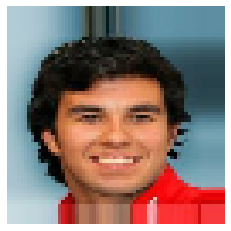

In [107]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * 255).astype("int32")[0])
    break

In [14]:
gan.compile()

In [15]:
gan.fit(
    dataset,
    epochs=epochs,
    callbacks=[GANMonitor(num_img=3, latent_dim=Z_DIM)]
)

Epoch 1/2
3166/3166 [==============================] - 11745s 4s/step - d_loss: 0.5618 - g_loss: 1.4270
INFO:tensorflow:Assets written to: g_checkpoint_0/assets
INFO:tensorflow:Assets written to: d_checkpoint_0/assets
Epoch 2/2
3166/3166 [==============================] - 11377s 4s/step - d_loss: 0.5708 - g_loss: 1.2944
INFO:tensorflow:Assets written to: g_checkpoint_1/assets
INFO:tensorflow:Assets written to: d_checkpoint_1/assets


In [16]:
gan.fit(
    dataset,
    epochs=3,
    callbacks=[GANMonitor(num_img=3, latent_dim=Z_DIM)]
)

Epoch 1/3
3166/3166 [==============================] - 9870s 3s/step - d_loss: 0.5301 - g_loss: 1.4426
INFO:tensorflow:Assets written to: g_checkpoint_0/assets
INFO:tensorflow:Assets written to: d_checkpoint_0/assets
Epoch 2/3
3166/3166 [==============================] - 24781s 8s/step - d_loss: 0.5032 - g_loss: 1.5859
INFO:tensorflow:Assets written to: g_checkpoint_1/assets
INFO:tensorflow:Assets written to: d_checkpoint_1/assets
Epoch 3/3
3166/3166 [==============================] - 10649s 3s/step - d_loss: 0.4432 - g_loss: 1.7493
INFO:tensorflow:Assets written to: g_checkpoint_2/assets
INFO:tensorflow:Assets written to: d_checkpoint_2/assets


In [19]:
gan.fit(
    dataset,
    epochs=2,
    callbacks=[GANMonitor(num_img=3, latent_dim=Z_DIM)]
)

Epoch 1/2
3166/3166 [==============================] - 10314s 3s/step - d_loss: 0.3805 - g_loss: 2.1076
INFO:tensorflow:Assets written to: g_checkpoint_0/assets
INFO:tensorflow:Assets written to: d_checkpoint_0/assets
Epoch 2/2
3166/3166 [==============================] - 10406s 3s/step - d_loss: 0.3187 - g_loss: 2.4930
INFO:tensorflow:Assets written to: g_checkpoint_1/assets
INFO:tensorflow:Assets written to: d_checkpoint_1/assets


## Training GAN (1 point + 2 for good results)

In [21]:
from keras.models import load_model

restored_gen = load_model('g_checkpoint_0')

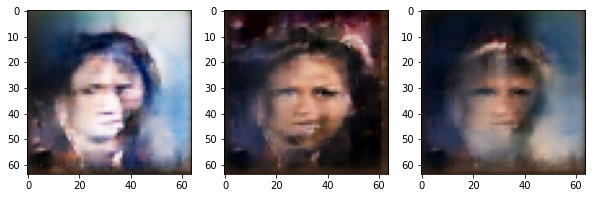

In [43]:
random_latent_vectors = tf.random.normal(shape=(3, 100))
generated_images = restored_gen(random_latent_vectors)
generated_images *= 255

fig, axs = plt.subplots(1, 3)
fig.set_figheight(10)
fig.set_figwidth(10)

for i in range(3):
    axs[i].imshow(np.clip(generated_images.numpy().astype(np.int32)[i], 0, 255))
#     img = tf.keras.preprocessing.image.array_to_img(generated_images[i])
#     img.save("generated_img_%03d_%d.png" % (1, i))

If you generated something that looks like a face - it's cool! Add 2 points to your mark.

## Face interpolation (1 point)

Let's interpolate between faces: generate two vectors $z_1$ and $z_2$ and get a batch of vectors of the form $\alpha\cdot z_1 + (1- \alpha)\cdot  z_2, \alpha \in [0,1].$ Generate faces on them and look at results. The generator displays pictures in the range from -1 to 1, so use the inverse transform function from the file utils.py.

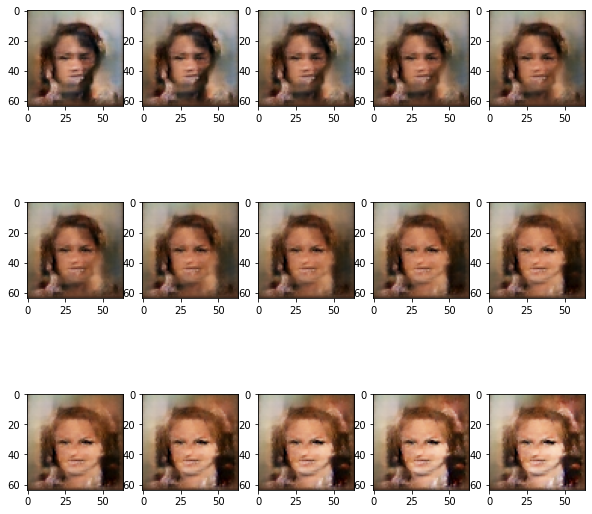

In [49]:
z1, z2 = tf.random.normal(shape=(1, 100)), tf.random.normal(shape=(1, 100))

fig, axs = plt.subplots(3, 5)
fig.set_figheight(10)
fig.set_figwidth(10)

for i, alpha in enumerate(np.linspace(0, 1, 15)):
    batchz = alpha * z1 + (1 - alpha) * z2
    generated_image = restored_gen(batchz) * 255
    generated_image = np.clip(generated_image.numpy().astype(np.int32), 0, 255)[0]
    axs[i // 5][i % 5].imshow(generated_image)

## Adding a smile (1 point + 1 point for good results)

Let's make face smiling. Find several vectors z, such that the generator generates smiling faces and not. Five vectors in every group should be enough (but the more, the better).

Calculate "smile vector" as mean of vectors z with generated smile on it minus mean of vectors z with generated not smile on it.

Look at the result of applying the smile vector: compare the results of generation before and after the addition of the smile vector.

If faces looks really cool, add bonus 1 point to your score.

In [ ]:
# n_cols = 2
# n_rows = 100

# lx,ly = 200, 200

# margin = 0.6 #inch
# spacing =0.3 #inch
# imsize = 3.5 #inch

# figwidth=n_cols*imsize+(n_cols-1)*spacing+2*margin
# figheight=n_rows*imsize*ly/lx+(n_rows-1)*spacing+2*margin

# left=margin/figwidth
# bottom = margin/figheight

# fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols, sharex=True, sharey=True)
# fig.set_size_inches(figwidth,figheight)
# fig.subplots_adjust(left=left, bottom=bottom, right=1.-left, top=1.-bottom, 
#                     wspace=spacing/imsize, hspace=spacing/imsize*lx/ly)


# # fig = plt.figure(figsize=(9, 9))
# axes[i][column].imshow(generated_image)
# axes[i][column].set_title('i = {}'.format(i))